In [0]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


In [187]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [0]:
import sqlite3
con = sqlite3.connect('/content/gdrive/My Drive/database.sqlite')  

In [211]:
filtered_data=pd.read_sql_query("""
SELECT * 
FROM REVIEWS
WHERE Score != 3 limit 100000""",con)
print(filtered_data.shape)

(100000, 10)


In [0]:
y=filtered_data['Score']
y=y[:100000][:]

In [213]:
x= filtered_data['Text']
print(len(x))
type(x)

100000


pandas.core.series.Series

In [214]:
y=y[:100000]
len(y)
print(y.head())

for i in range(len(y)):
  if y[i]<3:
    y[i]=0
  else:
    y[i]=1
print(y.head())

0    5
1    1
2    4
3    2
4    5
Name: Score, dtype: int64
0    1
1    0
2    1
3    0
4    1
Name: Score, dtype: int64


In [0]:
from sklearn.model_selection import train_test_split

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.33) #splitting the train  and test

In [0]:
x_train, x_cv, y_train, y_cv = train_test_split(x_train, y_train, test_size=0.33) # this is random splitting

In [217]:
print(x_train.shape, y_train.shape)
print(x_cv.shape, y_cv.shape)
print(x_test.shape, y_test.shape)

(44890,) (44890,)
(22110,) (22110,)
(33000,) (33000,)


In [0]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [0]:
tfidf = TfidfVectorizer(ngram_range=(1,2))

In [0]:
tfidf_fit = tfidf.fit(x_train)

In [0]:
x_train_tfidf = tfidf.transform(x_train)
x_cv_tfidf = tfidf.transform(x_cv)
x_test_tfidf = tfidf.transform(x_test)

In [223]:
print(x_train_tfidf.shape, y_train.shape)
print(x_cv_tfidf.shape, y_cv.shape)
print(x_test_tfidf.shape, y_test.shape)

(44890, 705608) (44890,)
(22110, 705608) (22110,)
(33000, 705608) (33000,)


# Hyper parameter Tuning

In [0]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

import matplotlib.pyplot as plt

y_cv = y_cv.astype(int)
y_train = y_train.astype(int)
y_test = y_test.astype(int)

x_train_auc =[]
x_cv_auc = []
k = [1,5,10,15,20,25,30,35,45,55]
#k = [5]
for i in k:
  neigh = KNeighborsClassifier(n_neighbors=i)
  neigh.fit(x_train_tfidf, y_train)
  y_train_pred = neigh.predict_proba(x_train_tfidf)[:,1]
  y_cv_pred = neigh.predict_proba(x_cv_tfidf)[:,1]
  x_train_auc.append(roc_auc_score(y_train, y_train_pred))
  x_cv_auc.append(roc_auc_score(y_cv, y_cv_pred))

 

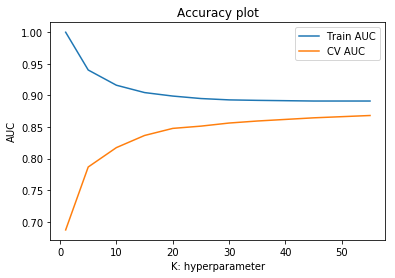

In [230]:
plt.plot(k, x_train_auc, label='Train AUC')
plt.plot(k, x_cv_auc, label="CV AUC")
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("Accuracy plot")
plt.show()



In [0]:
best_k = 15

# https://scikit-learn.org/stable/modules/generated/sklearn.metrics.roc_curve.html#sklearn.metrics.roc_curve
from sklearn.metrics import roc_curve, auc


neigh = KNeighborsClassifier(n_neighbors=best_k)
neigh.fit(x_train_tfidf, y_train)
# roc_auc_score(y_true, y_score) the 2nd parameter should be probability estimates of the positive class
# not the predicted outputs

train_fpr, train_tpr, thresholds = roc_curve(y_train, neigh.predict_proba(x_train_tfidf)[:,1])
test_fpr, test_tpr, thresholds = roc_curve(y_test, neigh.predict_proba(x_test_tfidf)[:,1])



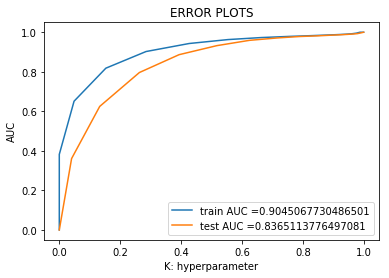

In [234]:
plt.plot(train_fpr, train_tpr, label="train AUC ="+str(auc(train_fpr, train_tpr)))
plt.plot(test_fpr, test_tpr, label="test AUC ="+str(auc(test_fpr, test_tpr)))
plt.legend()
plt.xlabel("K: hyperparameter")
plt.ylabel("AUC")
plt.title("ERROR PLOTS")
plt.show()

In [233]:
print("="*100)
from sklearn.metrics import confusion_matrix
print("Train confusion matrix")
print(confusion_matrix(y_train, neigh.predict(x_train_tfidf)))
print("Test confusion matrix")
print(confusion_matrix(y_test, neigh.predict(x_test_tfidf)))



Train confusion matrix
[[ 1762  5494]
 [  790 36844]]
Test confusion matrix
[[ 1125  4198]
 [  599 27078]]
